## NOTE


This notebook is intended for clean up and adding additional annotations to the dataset for downstream analysis. 

These analyses will be performed: 
1. [x] cell cycle (obs)
2. [x] generate marker list for each subpopulation
3. [x] Run GSEApy on GO_Biological_Processes 2018
4. [ ] cloupe file generation

### RE-naming & Clean up

In [ ]:
import sys
sys.path.append("../code")
from data_prep.io import *
from data_prep.processing import *
from plotting.plot_settings import *
from plotting.palettes import *
from plotting.plot_funcs import marker_violins, fix_aspect_scatter_with_legend, save_figure

In [1]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import scrublet as scr

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sc.settings.verbosity=3

In [2]:
sc.set_figure_params(dpi=150, color_map='Reds')
sns.set_style("white")
matplotlib.rcParams["figure.facecolor"]="white"

In [4]:
main_dir = "/projects/robson-lab/research/endometriosis/"
sample_id = "Endometriosis-revision-3"

sc.settings.figdir = f"{main_dir}figures/{sample_id}"

In [17]:
#import & re-name clusters in datasets
main = sc.read(f"{main_dir}/data/h5ad/{sample_id}/{sample_id}-scrubs-clean-final-20220103.h5ad")
mye = sc.read(f"{main_dir}/data/h5ad/{sample_id}/Myeloid/{sample_id}-final-mye-20220103.h5ad")
lym = sc.read(f"{main_dir}/data/h5ad/{sample_id}/TNK/{sample_id}-final-lym-20220104.h5ad")
#epi = sc.read(f"{main_dir}/data/h5ad/{sample_id}/Epithelial/{sample_id}-final-Epi-L2-20220105.h5ad")
epi = sc.read(f"{main_dir}/data/h5ad/{sample_id}/Epithelial/{sample_id}-final-Epi-20220119.h5ad")
stro = sc.read(f"{main_dir}/data/h5ad/{sample_id}/Stromal/{sample_id}-final-stro-20220103.h5ad")
endo = sc.read(f"{main_dir}/data/h5ad/{sample_id}/Endothelial/{sample_id}-final-endo-20220104.h5ad")
#org = sc.read(f"{main_dir}/data/h5ad/{sample_id}/non_immune/{sample_id}-epi-harmonized-20220105.h5ad")
org = sc.read(f"{main_dir}/data/h5ad/{sample_id}/non_immune/{sample_id}-epi-harmonized-20220121.h5ad")

In [18]:
#additional annotations
adatas = [main, mye, lym, epi, stro, endo, org]
#adatas = [epi, org] #repeat for new dataset

for adata in adatas:
    adata.obs["sample_type_rename"] = adata.obs.sample_type.map({
        "Eutopic" : "EuE",
        "Eutopic Normal" : "Ctrl",
        "Ectopic" : "EcP",
        "Ectopic Adj" : "EcPA",
        "Ectopic Ovary": "EcO",
        "nan":"nan"
    }).astype("category")

for adata in adatas[0:-1]:
    adata.obs["sample_type_rename"].cat.reorder_categories(
        ["Ctrl", "EuE", "EcP", "EcPA", "EcO"],inplace=True)

org.obs["sample_type_rename"].astype("category").cat.reorder_categories(
    ["Ctrl", "EuE", "EcP", "EcPA", "EcO","nan"], inplace=True)

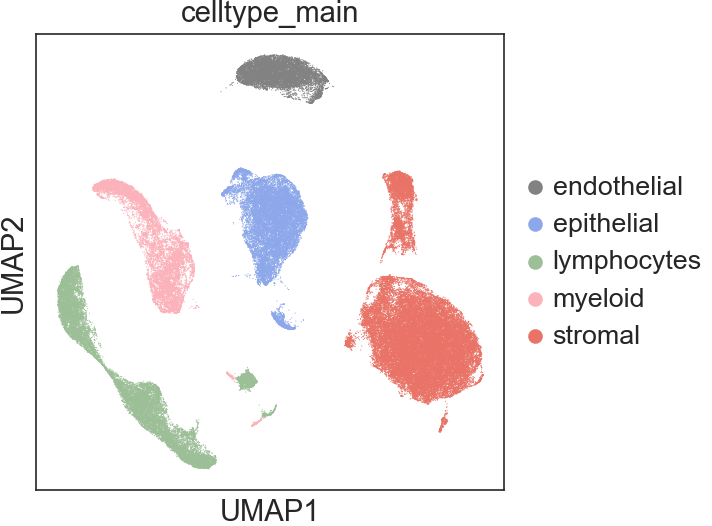

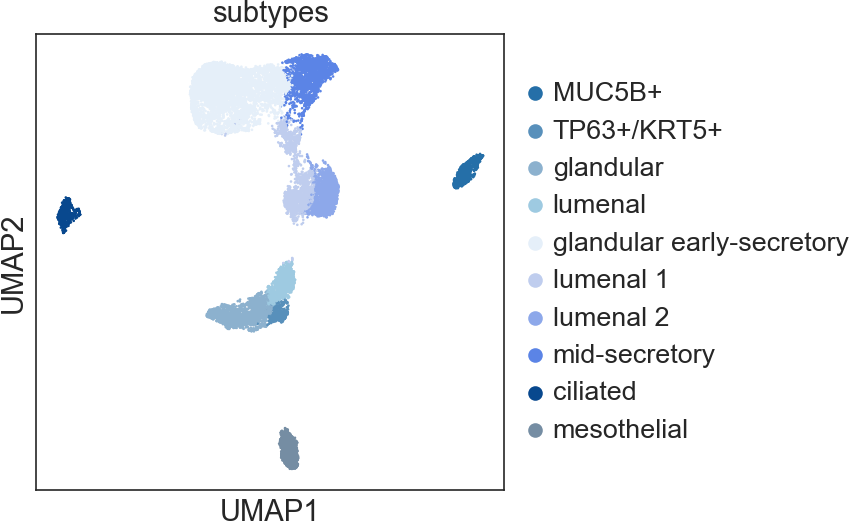

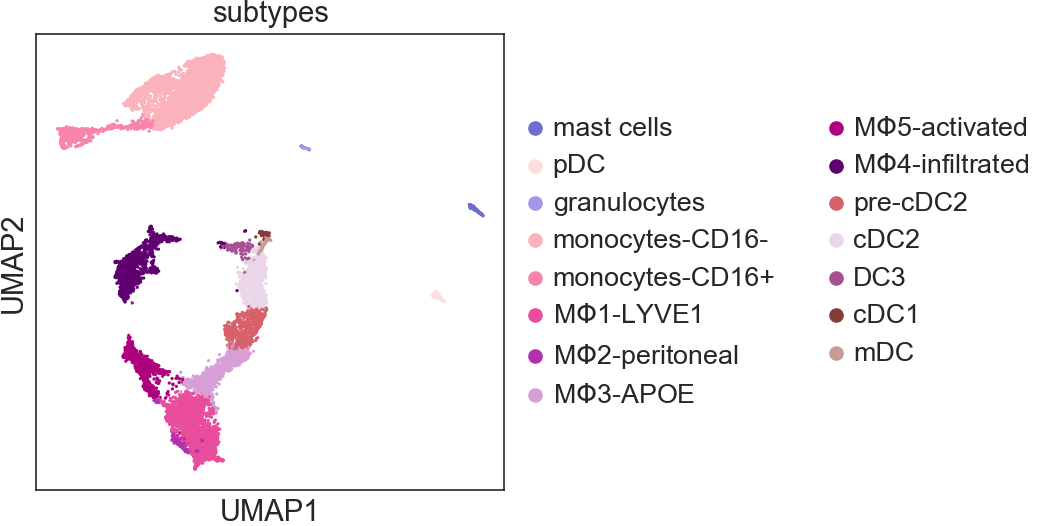

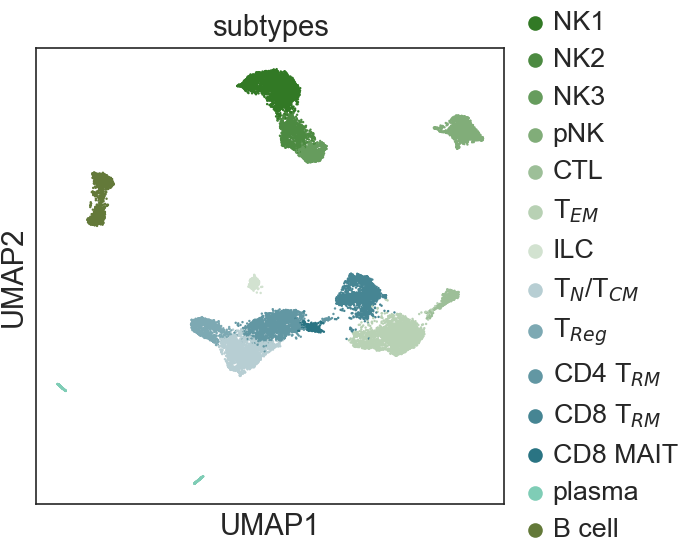

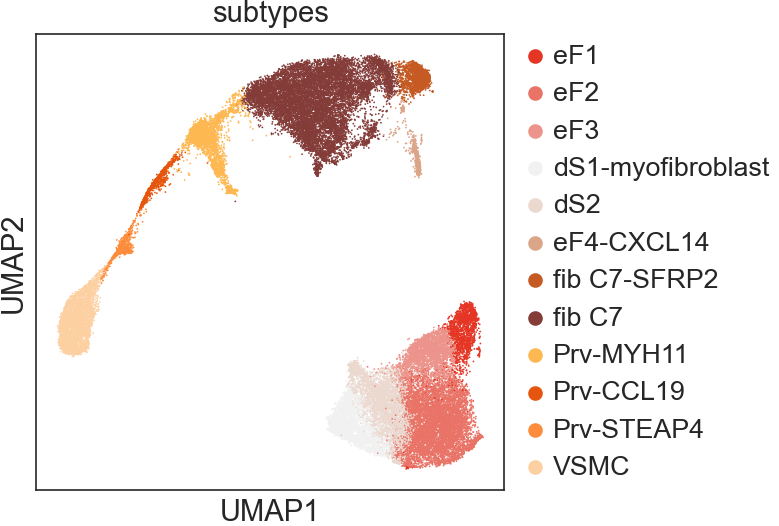

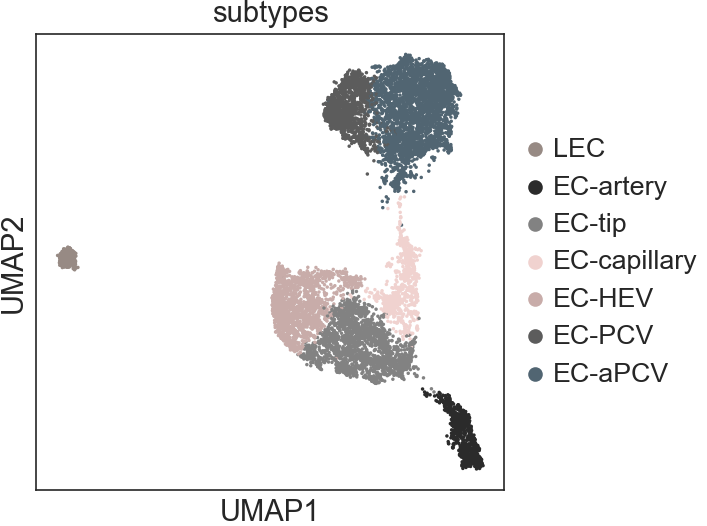

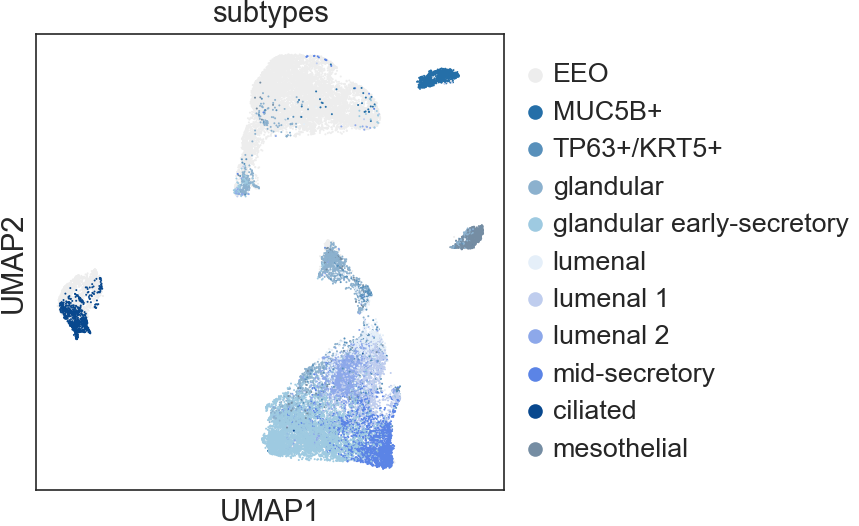

In [22]:
adatas = [main, epi, mye, lym,  stro, endo, org]
pals = [main_palette, epi_palette, mye_palette,lym_palette,  stro_palette, endo_palette, org_palette]

sc.pl.umap(main, color=["celltype_main"], palette=main_palette)
sc.pl.umap(epi, color=["subtypes"], palette=epi_palette)

for i,p in zip(adatas[2:],pals[2:]):
    sc.pl.umap(i, color=["subtypes"], palette=p)

---

In [23]:
def adata_cleanup(adata):    
    adata_copy = adata.copy()
    
    obs_to_keep = ["sequencing_saturation","n_genes_by_counts","total_counts",
                   "pct_counts_mitochondrial","pct_counts_hemoglobin",
                   "sampleid","PID","stage","sample_type_rename",
                   "celltype","celltype_main","subtypes","subtypes_L2","menstrual_phase"
                   "S_score","G2M_score","phase",
                   "hto","method","source","leiden_org_epi"]

    var_to_keep = ["gene_ids","highly_variable","means","dispersions","dispersions_norm"]

    uns_to_keep = ["output_dir","sampleid",
                   "celltype_main_colors","subtypes_colors","subtypes_L2_colors"
                   "neighbors","raw_dtype","umap","pca"]
    
    remove_obs = []
    remove_var = []

    for key in adata_copy.obs_keys():
        if key not in obs_to_keep:
            remove_obs.append(key)

    for key in adata_copy.var_keys():
        if key not in var_to_keep:
            remove_var.append(key)

    for key in adata_copy.uns_keys():
        if key not in uns_to_keep:
            del adata_copy.uns[key]

    adata_copy.obs.drop(remove_obs, axis=1, inplace=True)
    adata_copy.var.drop(remove_var, axis=1, inplace=True)
    return adata_copy

## 1. Cell cyle analysis

In [24]:
#Tirosh 2015, cell cycle gene list
genes = pd.read_csv("https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt",header=None)
cc_genes = genes[0].tolist()
s_genes = cc_genes[:43]
g2m_genes = cc_genes[43:]

In [25]:
#adatas = [main, epi, mye, lym,  stro, endo, org]
#names = ["main", "epi", "mye", "lym",  "stro", "endo", "org"]
#dirs = ["",'Epithelial','Myeloid', 'TNK',  'Stromal',  'Endothelial', "non_immune"]

##re-do for epi, org new dataset
adatas = [epi, org]
names = ["epi", "org"]
dirs = ['Epithelial',"non_immune"]

for adata,name,sdir in zip(adatas,names,dirs):
    sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
    final = adata_cleanup(adata)
    save_adata(final, f"{name}-final-cc", subdir = sdir)

calculating cell cycle phase
computing score 'S_score'
/home/tany/.conda/envs/endometriosis/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    finished: added
    'S_score', score of gene set (adata.obs).
    640 total control genes are used. (0:00:02)
computing score 'G2M_score'
/home/tany/.conda/envs/endometriosis/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    finished: added
    'G2M_score', score of gene set (adata.obs).
    688 total control genes are used. (0:00:02)
-->     'phase', cell cycle phase (adata.obs)
... storing 'phase' as categorical
calculating cell cycle phase
computing score 'S_sc

In [5]:
#import new adatas
main2 = sc.read(f"{main_dir}/data/h5ad/{sample_id}/{sample_id}-main-final-cc-20220105.h5ad")
mye2 = sc.read(f"{main_dir}/data/h5ad/{sample_id}/Myeloid/{sample_id}-mye-final-cc-20220105.h5ad")
lym2 = sc.read(f"{main_dir}/data/h5ad/{sample_id}/TNK/{sample_id}-lym-final-cc-20220105.h5ad")
epi2 = sc.read(f"{main_dir}/data/h5ad/{sample_id}/Epithelial/{sample_id}-epi-final-cc-20220119.h5ad")
stro2 = sc.read(f"{main_dir}/data/h5ad/{sample_id}/Stromal/{sample_id}-stro-final-cc-20220105.h5ad")
endo2 = sc.read(f"{main_dir}/data/h5ad/{sample_id}/Endothelial/{sample_id}-endo-final-cc-20220105.h5ad")
org2 = sc.read(f"{main_dir}/data/h5ad/{sample_id}/non_immune/{sample_id}-org-final-cc-20220119.h5ad")

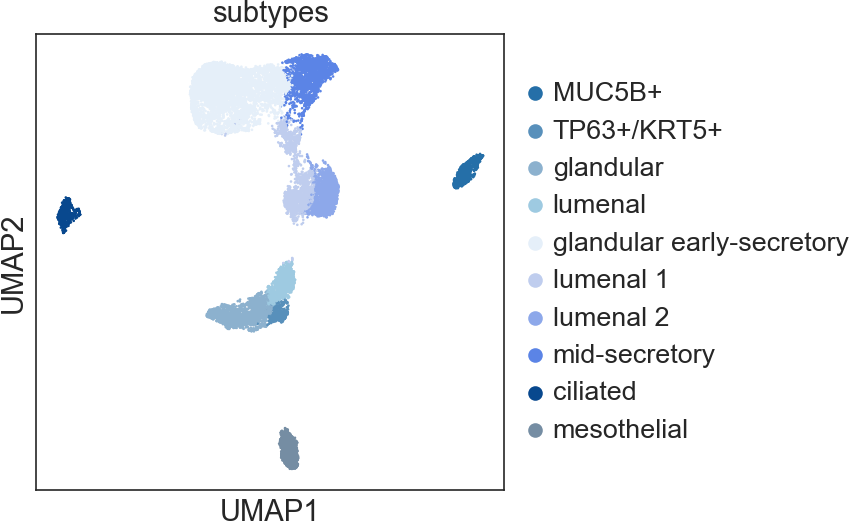

In [7]:
sc.pl.umap(epi2, color="subtypes")

### 2. export gene markers for each subpopulation

In [ ]:
adatas = [main2, epi2, stro2, mye2, lym2, endo2]
names = ["main", "epi", "stro","mye", "lym",  "endo"]
#dirs = ["",'Myeloid', 'TNK', 'Epithelial', 'Stromal',  'Endothelial', "non_immune"]

for adata,name in zip(adatas,names):
    adata.raw = sc.AnnData(adata.layers["raw"], var=adata.var, obs=adata.obs)
    if ("subtypes" in adata.obs_keys()) == False:
        compute_marker_genes(adata, groupby="celltype_main",use_raw = True, suffix = f"{name}-celltypes",save=True)
    elif ("subtypes_L2" in adata.obs_keys()) == False:
        compute_marker_genes(adata, groupby="subtypes",use_raw = True, suffix = f"{name}-subtypes",save=True)
    else:
        compute_marker_genes(adata, groupby="subtypes_L2",use_raw = True, suffix = f"{name}-subtypes_L2",save=True)

ranking genes


### 3. GSEApy prerank

Note: Run scripts in `11_create-matrix-for-sc-edgeR.ipynb` and `11_sc-edgeR.ipynb` first before running the code below

In [8]:
import gseapy as gp

In [9]:
subclusters = pd.read_csv(f"{main_dir}analysis/{sample_id}/DEG/edgeR-input/subtypelist.csv", sep=",", index_col=0)["0"].tolist()
for clustername in subclusters[15:]:
    deg = pd.read_csv(f"{main_dir}analysis/{sample_id}/DEG/edgeR-output/{clustername}-DEG.csv", 
                      sep=",", index_col=0)
    deg = deg[deg.FDR < 1e-05]
    pairs = deg.loc[:,deg.columns.str.contains("logFC")].columns.tolist()
    
    for pair in pairs:
        get_list = deg[pair].reset_index()
        get_list.rename(columns={"index":"names",pair:"logfoldchanges"},inplace=True)
        get_list.sort_values(by="logfoldchanges",ascending=False,inplace=True)
        res = gp.prerank(rnk=get_list, gene_sets="GO_Biological_Process_2018",
                         outdir=f"{main_dir}/analysis/{sample_id}/DEG/GSEA-output/{clustername}-{pair}/",
                         no_plot=True,verbose=False,permutation_num=200)
        terms = res.res2d[res.res2d.fdr<0.10].sort_values(by="nes",ascending=False)
        terms.to_csv(f"{main_dir}/analysis/{sample_id}/DEG/GSEA-output/GOBP-filtered/gsea_{clustername}-{pair}.csv")

In [10]:
#for organoid
deg = pd.read_csv(f"{main_dir}analysis/{sample_id}/DEG/edgeR-output/organoid-DEG.csv", 
                  sep=",", index_col=0)
deg = deg[deg.FDR < 1e-05]
pairs = deg.loc[:,deg.columns.str.contains("logFC")].columns.tolist()

for pair in pairs:
    get_list = deg[pair].reset_index()
    get_list.rename(columns={"index":"names",pair:"logfoldchanges"},inplace=True)
    get_list.sort_values(by="logfoldchanges",ascending=False,inplace=True)
    res = gp.prerank(rnk=get_list, gene_sets="GO_Biological_Process_2018",
                     outdir=f"{main_dir}/analysis/{sample_id}/DEG/GSEA-output/organoid-{pair}/",
                     no_plot=True,verbose=False,permutation_num=200)
    terms = res.res2d[res.res2d.fdr<0.10].sort_values(by="nes",ascending=False)
    terms.to_csv(f"{main_dir}/analysis/{sample_id}/DEG/GSEA-output/GOBP-filtered/gsea_organoid-{pair}.csv")

In [33]:
#GSEA MUC5B+ markers
markers =  pd.read_csv(f"{main_dir}/analysis/{sample_id}/markers/{sample_id}-epi-subtypes-markers.csv")
sc.tl.rank_genes_groups(epi, groupby="subtypes", use_raw=True, method="wilcoxon", n_genes=5000)

df = sc.get.rank_genes_groups_df(epi, group=["MUC5B+"])
deg = df[df.pvals_adj < 0.01]

#df = markers[markers.cluster == "MUC5B+"]
gl = deg.loc[:, ["names","logfoldchanges"]]

res = gp.prerank(rnk=gl, gene_sets="GO_Biological_Process_2018",
                 outdir=f"{main_dir}/analysis/{sample_id}/DEG/GSEA-output/",
                 no_plot=True,verbose=False,permutation_num=500)
terms = res.res2d[res.res2d.fdr<0.10].sort_values(by="nes",ascending=False)
terms.to_csv(f"{main_dir}/analysis/{sample_id}/DEG/GSEA-output/GOBP-filtered/gsea_muc5b.csv")